# Loading libraries

In [1]:
import sys
import os
import yaml
import pandas as pd
import numpy as np
sys.path.insert(1, '..')
os.chdir('..')

import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sklearn
import optuna

from darts import models
from darts import metrics
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler

from data_formatter.base import *

# Processing raw data and adding covariates

In [207]:
filenames = []
for root, dir, files in os.walk('raw_data/Colas2019'):
  for file in files:
    if '.csv' in file:
      filenames.append(os.path.join(root, file))
      
# next we loop through each file
nfiles = len(files)

count = 0
for file in filenames:
  # read in data and extract id from filename
  curr = pd.read_csv(file)
  curr['id'] = int(file.split()[1].split(".")[0])
  # select desired columns, rename, and drop nas
  curr = curr[['id', 'hora', 'glucemia']]
  curr.rename(columns = {'hora': 'time', 'glucemia': 'gl'}, inplace=True)
  curr.dropna(inplace=True)

  # calculate time (only given in hms) as follows:
  # (1) get the time per day in seconds, (2) get the time differences, and correct for the day crossove (< 0)
  # (3) take the cumulative sum and add the cumulative number of seconds from start to the base date
  # thus the hms are real, while the year, month, day are fake
  time_secs = []
  for i in curr['time']:
      time_secs.append(int(i.split(":")[0])*60*60 + int(i.split(":")[1])*60 + int(i.split(":")[2])*1)
  time_diff = np.diff(np.array(time_secs)).tolist()
  time_diff_adj = [x if x > 0 else 24*60*60 + x for x in time_diff]
  time_diff_adj.insert(0, 0)
  cumin = np.cumsum(time_diff_adj)
  datetime = pd.to_datetime('2012-01-01') + pd.to_timedelta(cumin, unit='sec')
  curr['time'] = datetime
  curr['id'] = curr['id'].astype('int')
  curr.reset_index(drop=True, inplace=True)

  if count == 0:
    df = curr
    count += 1
  else:
    df = pd.concat([df, curr])

In [211]:
# join with covariates
covariates = pd.read_csv('raw_data/Colas2019/clinical_data.txt', sep = " ")
covariates['id'] = covariates.index

combined = pd.merge(
    df, covariates, how = "left"
)

combined.to_csv('raw_data/Colas2019_processed.csv')

# Check statistics of the data

In [3]:
import matplotlib.pyplot as plt

# load yaml config file
with open('./config/colas.yaml', 'r') as f:
    config = yaml.safe_load(f)

# set interpolation params for no interpolation
new_config = config.copy()
new_config['interpolation_params']['gap_threshold'] = 5
new_config['interpolation_params']['min_drop_length'] = 0
# set split params for no splitting
new_config['split_params']['test_percent_subjects'] = 0
new_config['split_params']['length_segment'] = 0
# set scaling params for no scaling
new_config['scaling_params']['scaler'] = 'None'

formatter = DataFormatter(new_config)

--------------------------------
Loading column definition...
Checking column definition...
Loading data...


c:\Users\L Chun\Documents\Tamu\CGM_project\GitHub\GluNet\data_formatter\base.py:51: DtypeWarning: Columns (4,5,6,7,10) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(self.params['data_csv_path'], index_col=self.params['index_col'], na_filter=False)


Checking for NA values...
Setting data types...
Dropping columns / rows...
Encoding data...
	Updated column definition:
		id: REAL_VALUED (ID)
		time: DATE (TIME)
		gl: REAL_VALUED (TARGET)
		time_year: REAL_VALUED (KNOWN_INPUT)
		time_month: REAL_VALUED (KNOWN_INPUT)
		time_day: REAL_VALUED (KNOWN_INPUT)
		time_hour: REAL_VALUED (KNOWN_INPUT)
		time_minute: REAL_VALUED (KNOWN_INPUT)
Interpolating data...
	Dropped segments: 0
	Extracted segments: 283
	Interpolated values: 4
	Percent of values interpolated: 0.00%
Splitting data...
	Train: 114247 (100.00%)
	Val: 0 (0.00%)
	Test: 0 (0.00%)
Scaling data...
	No scaling applied
Data formatting complete.
--------------------------------


In [4]:
# print min, max, median, mean, std of segment lengths
segment_lens = []
for group, data in formatter.train_data.groupby('id_segment'):
    segment_lens.append(len(data))
print('Train segment lengths:')
print('\tMin: ', min(segment_lens))
print('\tMax: ', max(segment_lens))
print('\tMedian: ', np.median(segment_lens))
print('\tMean: ', np.mean(segment_lens))
print('\tStd: ', np.std(segment_lens))

Train segment lengths:
	Min:  1
	Max:  576
	Median:  576.0
	Mean:  403.69964664310953
	Std:  223.33792449061625


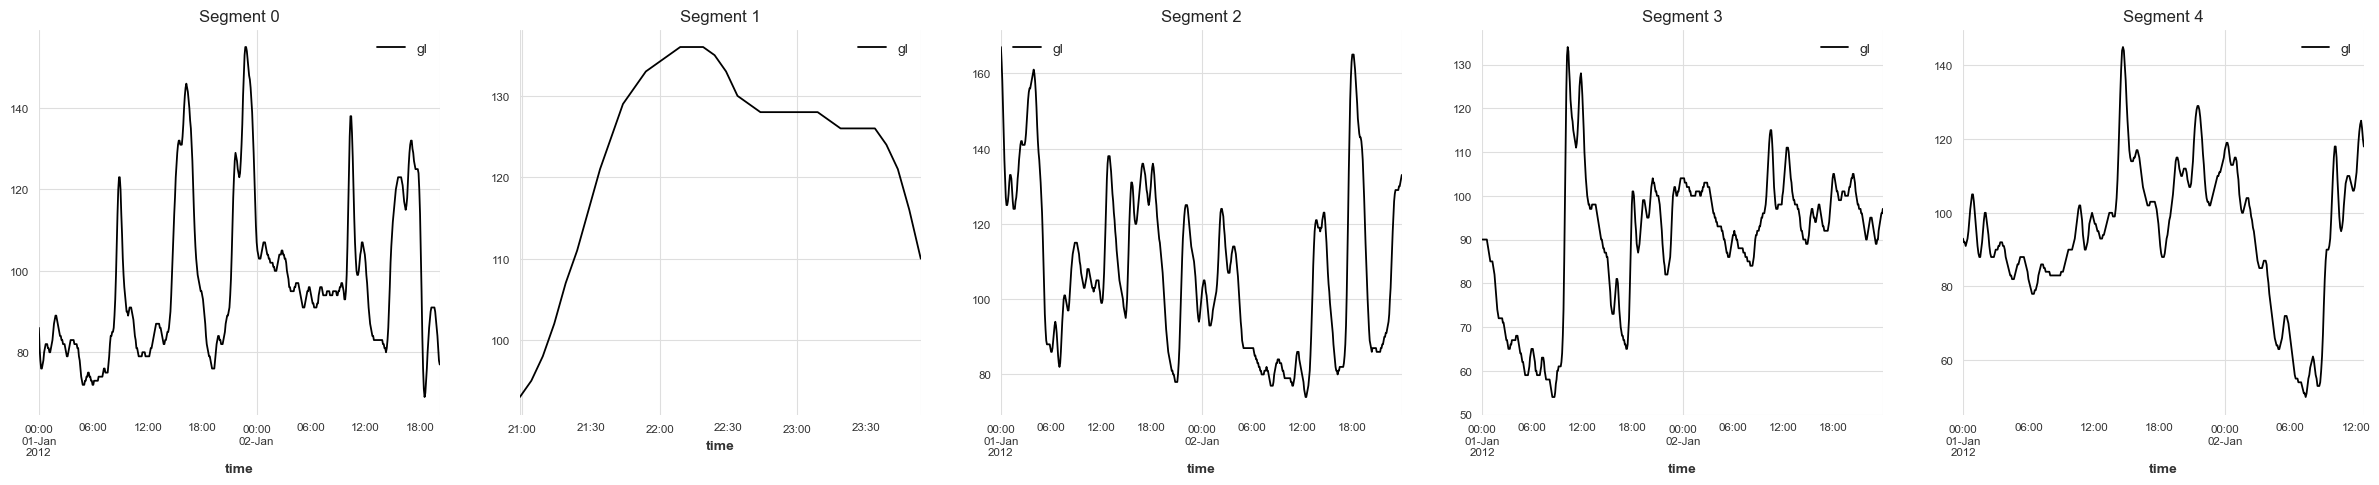

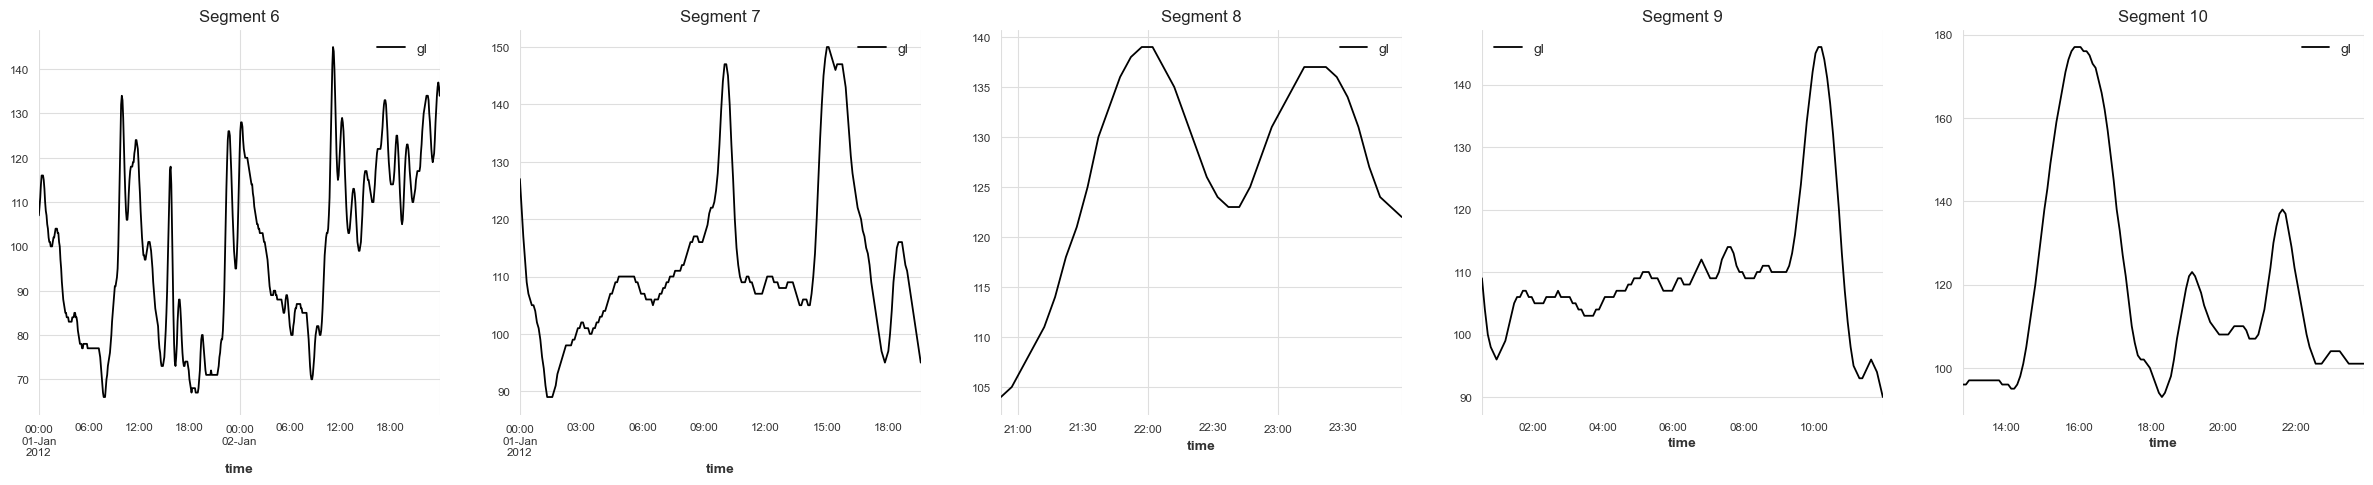

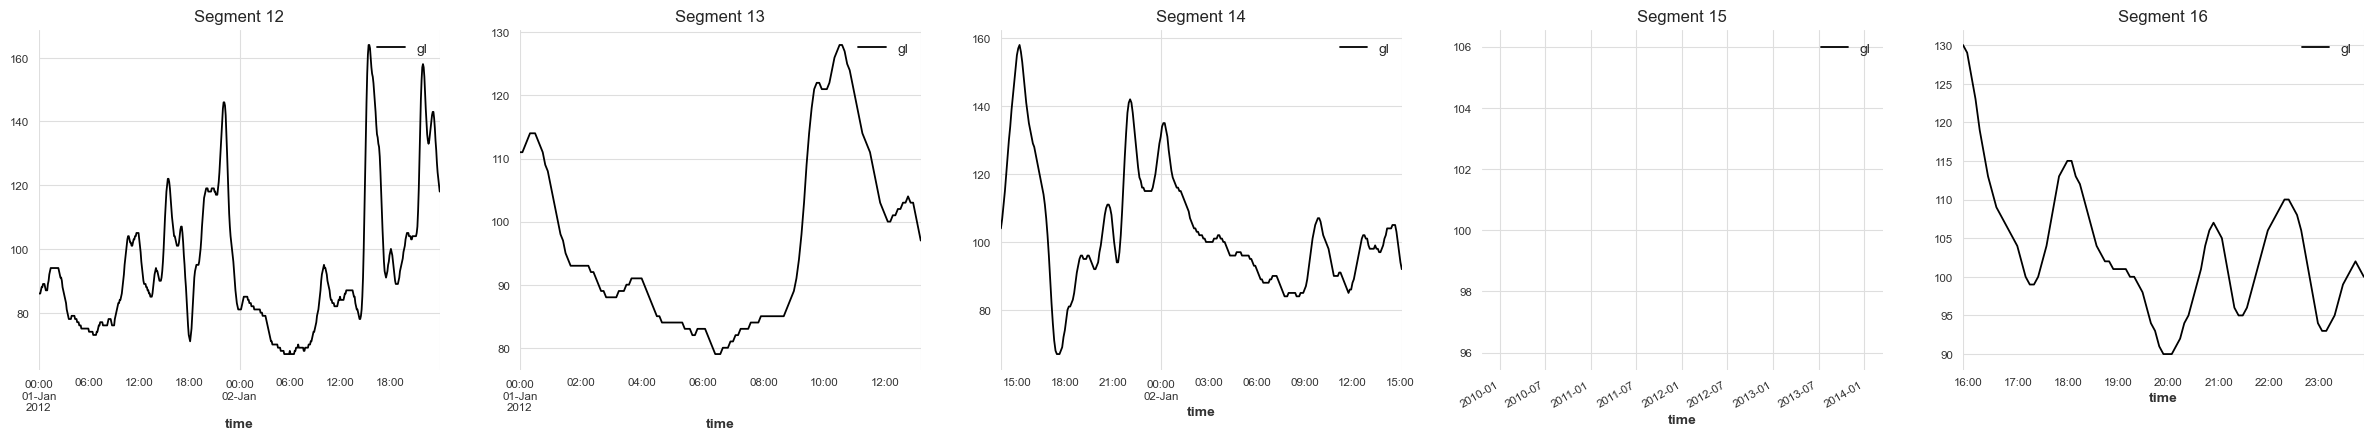

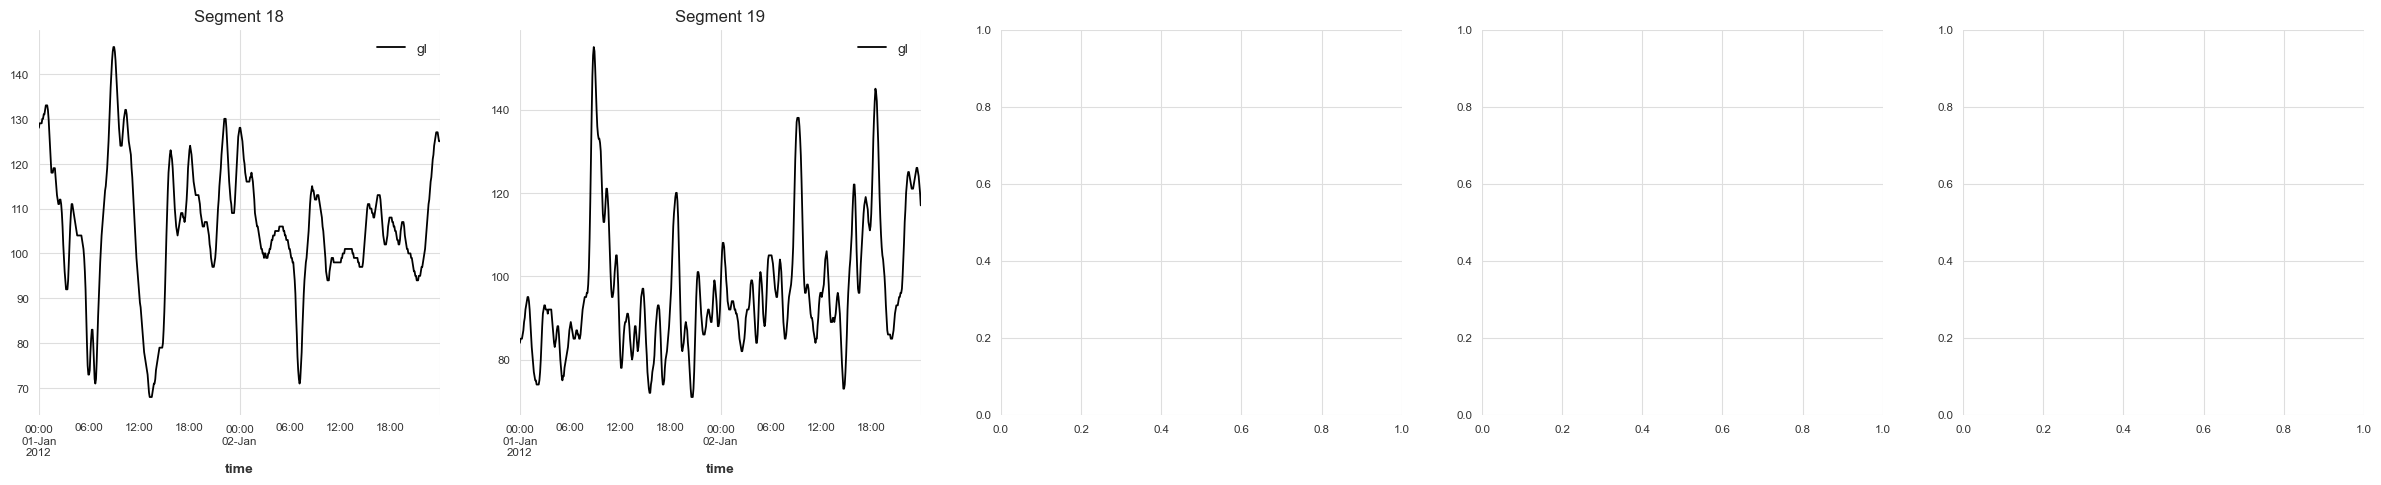

In [5]:
# plot each segment
num_segments = formatter.train_data['id_segment'].nunique()

counter = 0
break_counter = 0
for i, (group, data) in enumerate(formatter.train_data.groupby('id_segment')):

    if break_counter == 20: break
    break_counter += 1

    if counter == 5:
        counter = 0
        continue

    if counter == 0:
        fig, axs = plt.subplots(1, 5, figsize=(30, 5))
        
    if counter < 5:
        data.plot(x='time', y='gl', ax=axs[counter], title='Segment {}'.format(group))
        counter += 1

Segment 1 is too short
Segment 5 is too short
Segment 7 is too short
Segment 8 is too short
Segment 9 is too short
Segment 10 is too short
Segment 13 is too short
Segment 14 is too short
Segment 15 is too short
Segment 16 is too short


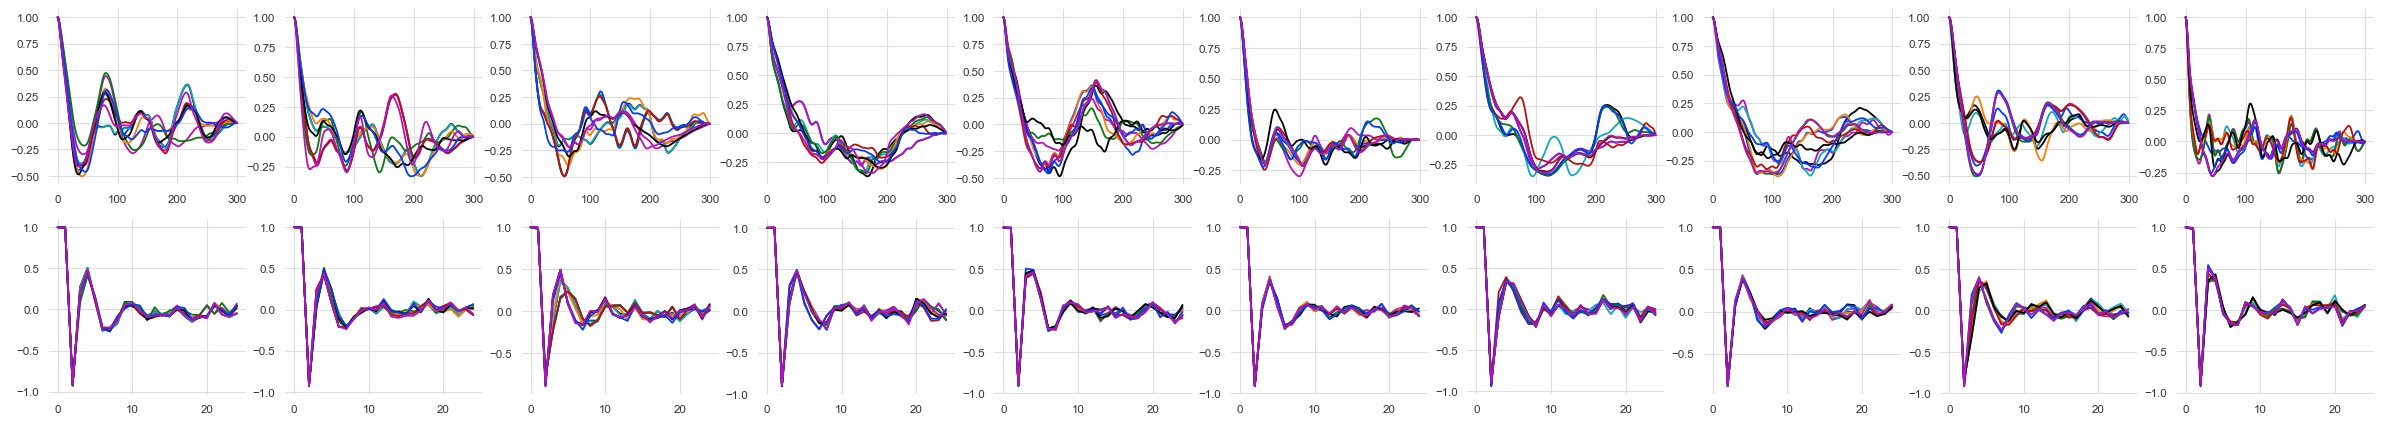

In [6]:
# plot acf of random samples from segments
counter = 0
lags = 300

break_counter = 0

for i, (group, data) in enumerate(formatter.train_data.groupby('id_segment')):

    if break_counter == 20: break
    break_counter += 1

    if counter == 10:
        counter = 0
        continue

    if len(data) < lags + 10:
        print('Segment {} is too short'.format(group))
        continue

    if counter == 0:
        fig, ax = plt.subplots(2, 10, figsize=(30, 5))
        
    if counter < 10:

        data = data['gl']
        # select 10 random samples from index of data
        sample = np.random.choice(range(len(data))[:-lags], 10, replace=False)

        # plot acf / pacf of each sample
        for j in sample:
            acf, acf_ci = sm.tsa.stattools.acf(data[j:j+lags], nlags=lags, alpha=0.05)
            pacf, pacf_ci = sm.tsa.stattools.pacf(data[j:j+lags], method='ols-adjusted', alpha=0.05)
            ax[0, counter].plot(acf)
            ax[1, counter].plot(pacf)        
            
        counter += 1

# Change the config according to the observations above

In [7]:
# set interpolation params for no interpolation
config['interpolation_params']['gap_threshold'] = 45
config['interpolation_params']['min_drop_length'] = 192
# set split params for no splitting
config['split_params']['test_percent_subjects'] = 0.1
config['split_params']['length_segment'] = 192
# set scaling params for no scaling
config['scaling_params']['scaler'] = 'None'

formatter = DataFormatter(config)

--------------------------------
Loading column definition...
Checking column definition...
Loading data...


c:\Users\L Chun\Documents\Tamu\CGM_project\GitHub\GluNet\data_formatter\base.py:51: DtypeWarning: Columns (4,5,6,7,10) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(self.params['data_csv_path'], index_col=self.params['index_col'], na_filter=False)


Checking for NA values...
Setting data types...
Dropping columns / rows...
Encoding data...
	Updated column definition:
		id: REAL_VALUED (ID)
		time: DATE (TIME)
		gl: REAL_VALUED (TARGET)
		time_year: REAL_VALUED (KNOWN_INPUT)
		time_month: REAL_VALUED (KNOWN_INPUT)
		time_day: REAL_VALUED (KNOWN_INPUT)
		time_hour: REAL_VALUED (KNOWN_INPUT)
		time_minute: REAL_VALUED (KNOWN_INPUT)
Interpolating data...
	Dropped segments: 63
	Extracted segments: 205
	Interpolated values: 241
	Percent of values interpolated: 0.22%
Splitting data...
	Train: 37857 (38.80%)
	Val: 31296 (32.08%)
	Test: 39658 (40.65%)
Scaling data...
	No scaling applied
Data formatting complete.
--------------------------------


# Program the model

## Convert data and (optional) scaling

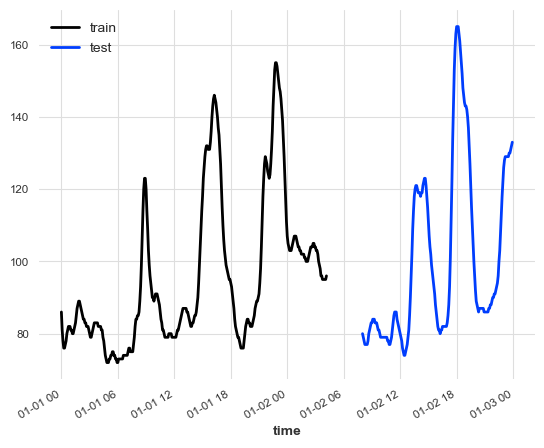

In [8]:
# build target series
target_col = formatter.get_column('target')
time_col = formatter.get_column('time')
group_col = formatter.get_column('sid')
train_series = TimeSeries.from_group_dataframe(formatter.train_data, 
                                               group_cols = group_col, 
                                               time_col = time_col, 
                                               value_cols = target_col)
val_series = TimeSeries.from_group_dataframe(formatter.val_data,
                                             group_cols = group_col,
                                             time_col = time_col,
                                             value_cols = target_col)
test_series = TimeSeries.from_group_dataframe(formatter.test_data,
                                              group_cols = group_col,
                                              time_col = time_col,
                                              value_cols = target_col)

# build static covariates series
static_cols = formatter.get_column('static_covs')
if static_cols is not None:
    static_cols += [formatter.get_column('id')]
else:
    static_cols = [formatter.get_column('id')]
train_static = TimeSeries.from_group_dataframe(formatter.train_data, 
                                               group_cols = group_col, 
                                               time_col = time_col, 
                                               value_cols = static_cols)
val_static = TimeSeries.from_group_dataframe(formatter.val_data,
                                             group_cols = group_col,
                                             time_col = time_col,
                                             value_cols = static_cols)
test_static = TimeSeries.from_group_dataframe(formatter.test_data,
                                              group_cols = group_col,
                                              time_col = time_col,
                                              value_cols = static_cols)

# build dynamic covariates series
dynamic_cols = formatter.get_column('dynamic_covs')
if dynamic_cols is not None:
    train_dynamic = TimeSeries.from_group_dataframe(formatter.train_data, 
                                                    group_cols = group_col, 
                                                    time_col = time_col, 
                                                    value_cols = dynamic_cols)
    val_dynamic = TimeSeries.from_group_dataframe(formatter.val_data,
                                                  group_cols = group_col,
                                                  time_col = time_col,
                                                  value_cols = dynamic_cols)
    test_dynamic = TimeSeries.from_group_dataframe(formatter.test_data,
                                                   group_cols = group_col,
                                                   time_col = time_col,
                                                   value_cols = dynamic_cols)

# build future covariates series
future_cols = formatter.get_column('future_covs')
if future_cols is not None:
    train_future = TimeSeries.from_group_dataframe(formatter.train_data, 
                                                   group_cols = group_col, 
                                                   time_col = time_col, 
                                                   value_cols = future_cols)
    val_future = TimeSeries.from_group_dataframe(formatter.val_data,
                                                 group_cols = group_col,
                                                 time_col = time_col,
                                                 value_cols = future_cols)
    test_future = TimeSeries.from_group_dataframe(formatter.test_data,
                                                  group_cols = group_col,
                                                  time_col = time_col,
                                                  value_cols = future_cols)

train_series[0].plot(label='train')
test_series[0].plot(label='test')

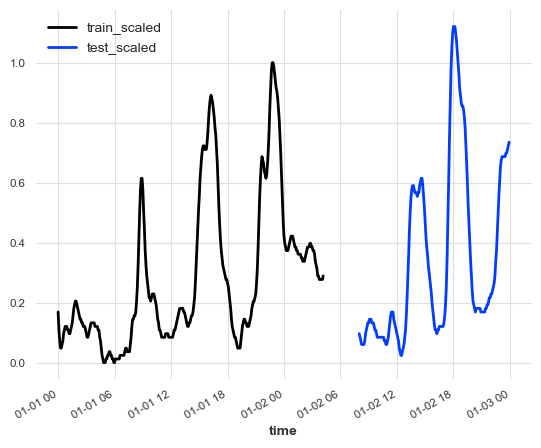

In [9]:
# scale the data
scaler = Scaler()
scaler.fit(train_series)
train_series_scaled = scaler.transform(train_series)
val_series_scaled = scaler.transform(val_series)
test_series_scaled = scaler.transform(test_series)

# scale covariates
scaler_static = Scaler()
if static_cols is not None:
    scaler_static.fit(train_static)
    train_static_scaled = scaler_static.transform(train_static)
    val_static_scaled = scaler_static.transform(val_static)
    test_static_scaled = scaler_static.transform(test_static)

# scale dynamic covariates
scaler_dynamic = Scaler()
if dynamic_cols is not None:
    scaler_dynamic.fit(train_dynamic)
    train_dynamic_scaled = scaler_dynamic.transform(train_dynamic)
    val_dynamic_scaled = scaler_dynamic.transform(val_dynamic)
    test_dynamic_scaled = scaler_dynamic.transform(test_dynamic)

# scale future covariates
scaler_future = Scaler()
if future_cols is not None:
    scaler_future.fit(train_future)
    train_future_scaled = scaler_future.transform(train_future)
    val_future_scaled = scaler_future.transform(val_future)
    test_future_scaled = scaler_future.transform(test_future)

train_series_scaled[0].plot(label='train_scaled')
test_series_scaled[0].plot(label='test_scaled')

## ARIMA model

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
arima = models.ARIMA(p=1, d=1, q=1, seasonal_order=(0, 0, 0, 0))
forecasts = arima.historical_forecasts(val_series_scaled, 
                                       train_length=156,
                                       forecast_horizon=12,
                                       stride=1,
                                       retrain=True,
                                       last_points_only=True,
                                       verbose=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

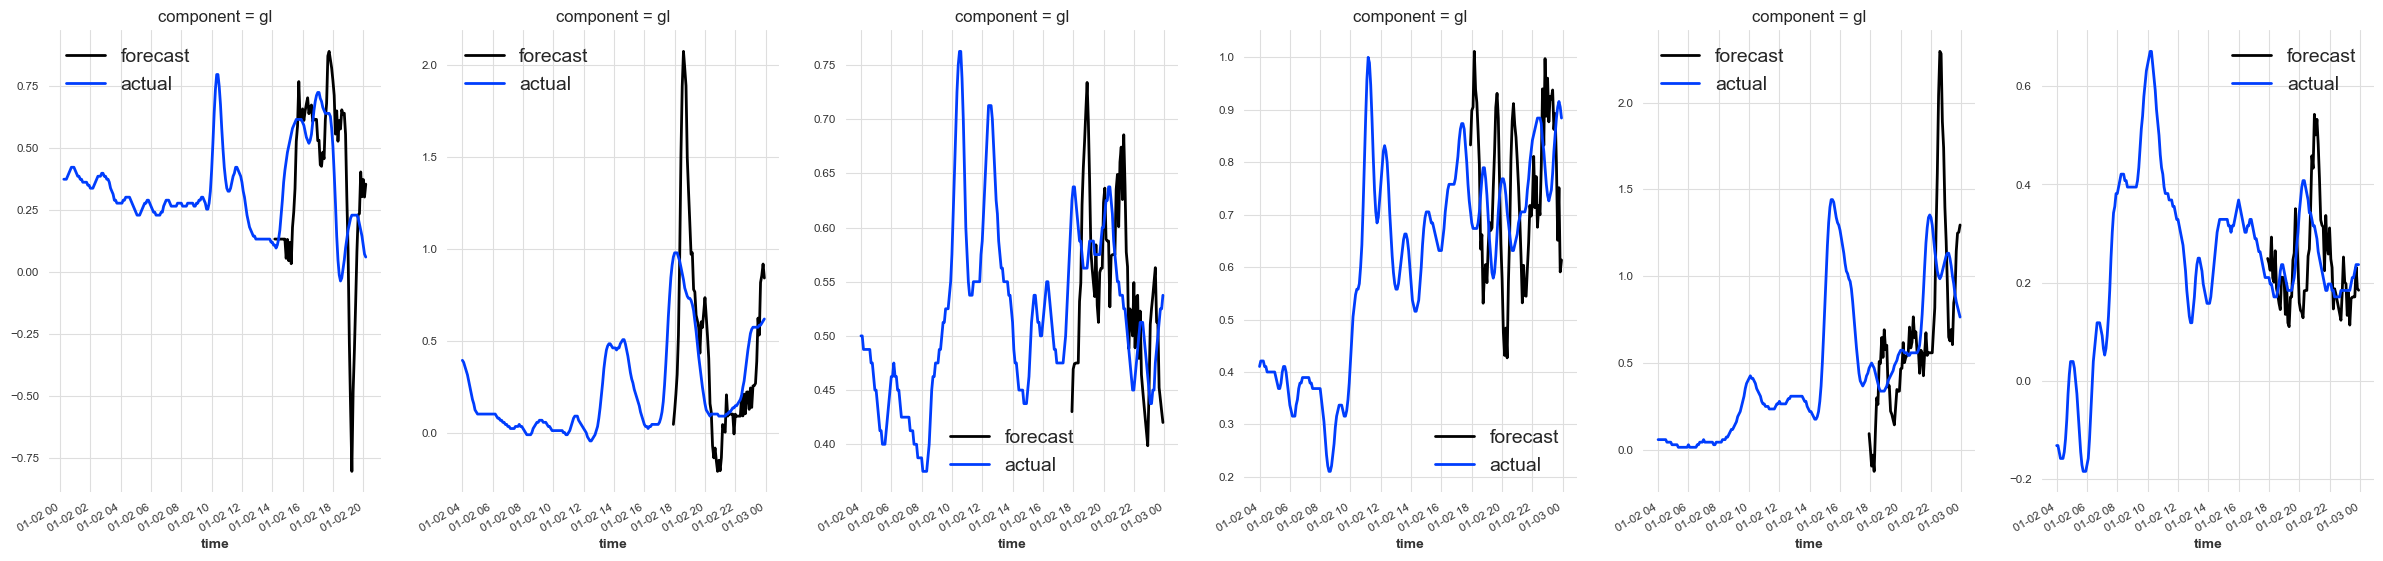

In [ ]:
fig, axs = plt.subplots(1, 6, figsize=(30, 6))
for i in range(6):
    forecasts[i].plot(label='forecast', ax=axs[i])
    val_series_scaled[i].plot(label='actual', ax=axs[i])
    axs[i].legend(fontsize=14)

In [ ]:
arima = models.ARIMA()

# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 100, 192)
    out_len = 12

    # Hyperparameters
    p = trial.suggest_int("p", 1, 5) # AR terms
    d = trial.suggest_int("d", 1, 5) # Order of differencing
    q = trial.suggest_int("q", 1, 5) # MA terms 

    # build the TCN model
    model = models.ARIMA(
        p=p, d=d, q=q,
        seasonal_order=(0, 0, 0, 0)
    )

    # backtest on the validation set
    errors = model.backtest(val_series_scaled,
                            train_length=in_len,
                            forecast_horizon=out_len,
                            stride=1,
                            retrain=True,
                            verbose=False,
                            metric=metrics.rmse,
                            last_points_only=False,
                            )
    avg_error = np.mean(errors)

    return avg_error


# for convenience, print some optimization trials information
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


# optimize hyperparameters by minimizing the rmse on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1, callbacks=[print_callback])


[I 2023-01-31 22:21:28,716] A new study created in memory with name: no-name-2bb8557f-ae39-4bb1-b2ed-36502928a5ad
[I 2023-02-01 01:07:12,345] Trial 0 finished with value: 0.3875742447629338 and parameters: {'in_len': 105, 'p': 2, 'd': 3, 'q': 1}. Best is trial 0 with value: 0.3875742447629338.


Current value: 0.3875742447629338, Current params: {'in_len': 105, 'p': 2, 'd': 3, 'q': 1}
Best value: 0.3875742447629338, Best params: {'in_len': 105, 'p': 2, 'd': 3, 'q': 1}
